# CopyCat: Example Usage on Argsme

This notebook assumes that you habe a jupyter notebook with CopyCat installed.
To start a jupyter notebook with CopyCat installed and your local directory mounted, run:
```
docker run --rm -ti -v ${PWD}:/home/jovyan -p 8888:8888 webis/chatnoir-copycat:1.0-jupyter
```


Then, we use the CopyCat cli to deduplicate run files submitted to the [Touché](https://webis.de/events/touche-20/) shared task on argument retrieval. The corpus of the shared task is the [args.me corpus](https://zenodo.org/record/3734893#.YETkhiso_rk) which contains 387,740 arguments crawled from  four debate portals (debatewise.org, idebate.org, debatepedia.org, anddebate.org).

## Step 1: Download the argsme anserini index

The following code downloads the argsme index for Anserini that we use for the deduplication analysis on the argsme corpus.

In [2]:
import os.path
import seaborn as sns
INDEX='copycat-on-argsme-data/index'
RUN_DIR='copycat-on-argsme-data/touche-runs-task1-2020'

!mkdir -p copycat-on-argsme-data
if not os.path.isfile('copycat-on-argsme-data/argsme-index.tar.gz') or not os.path.isdir(INDEX):
    !wget -O copycat-on-argsme-data/argsme-index.tar.gz 'https://files.webis.de/data-in-progress/touche20/argsme-anserini-premise-conclusion-porter-stemmer.tar.gz'
    !tar -xvzf copycat-on-argsme-data/argsme-index.tar.gz -C copycat-on-argsme-data
    
    !wget -O copycat-on-argsme-data/touche-runs-task1-2020.zip  https://webis.de/events/touche-21/runs-task-1-2020.zip
    !unzip copycat-on-argsme-data/touche-runs-task1-2020.zip -d $RUN_DIR
else:
    print('Argsme index is already downloaded.')


Argsme index is already downloaded.


# Step 2: Verify the Download; Double Check the Document Preprocessing

Now that we have the argsme index, we double check that our configured preprocessing of documents ([see here for all options](https://github.com/chatnoir-eu/copycat/blob/master/copycat-modules/document-preprocessing/README.md)) is suitable for deduplication.

In [2]:
!cp $RUN_DIR/runs-task-1/touche-2020-first-task-dataset-v2/'Swordsman Baseline'/Run/run.txt delete-me-baseline-run-argsme

!../bash/copy-cat.sh \
    --output copycat-on-argsme-data/delete-me-run-baseline-top100.jsonl \
    --input delete-me-baseline-run-argsme \
    --similarities "url s3 cosine(3+5-grams) cosine(8-grams) cosine(1-grams) simhash(1-grams) simhash(3+5-grams) md5 text-profile" \
    --s3Threshold 0.6 \
    --threads 5 \
    --ranks 100 \
    --documents AnseriniIndex \
    --anseriniIndex $INDEX

The specified output 'copycat-on-argsme-data/delete-me-run-baseline-top100.jsonl' exists.
Skip...


In [3]:
!../bash/copy-cat.sh \
    --output copycat-on-argsme-data/delete-me-run-baseline-top1000.jsonl \
    --input delete-me-baseline-run-argsme \
    --similarities "url s3 cosine(3+5-grams) cosine(8-grams) cosine(1-grams) simhash(1-grams) simhash(3+5-grams) md5 text-profile" \
    --s3Threshold 0.6 \
    --threads 5 \
    --ranks 1000 \
    --documents AnseriniIndex \
    --anseriniIndex $INDEX

The specified output 'copycat-on-argsme-data/delete-me-run-baseline-top1000.jsonl' exists.
Skip...


In [123]:
import json
import pandas as pd

def eval_with_threshold(threshold, run_file_name):
    rows = []
    with open(run_file_name) as jsonl_file:
        for jsonl in jsonl_file:
            dedup_data = json.loads(jsonl)
            docs_to_remove = []
            
            for sim in dedup_data['similarities']:
                if sim['similarities']['s3'] >=  threshold:
                    docs_to_remove += [sim['secondId']]

                
            rows += [{
                    'topic': dedup_data['topic'],
                    'duplicates': len(set(docs_to_remove)),
                    'docs': dedup_data['docs'],
                }]

    return rows

def eval_runs_with_threshold(threshold, run_files):
    rows = []
    for r in run_files:
        rows += eval_with_threshold(threshold, r)
    
    return pd.DataFrame(rows)

In [5]:
DEDUP_TARGET_DIR='copycat-on-argsme-data/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df = eval_runs_with_threshold(0.82, ALL_DIRS)
df['redundancy'] = df['duplicates']/df['docs']

In [6]:
df[['docs', 'redundancy']].groupby('docs').mean()

,redundancy
docs,
100,0.0256
1000,0.0220


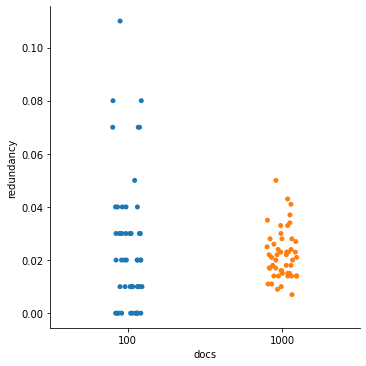

In [8]:
import seaborn as sns
sns.catplot(data=df, x='docs', y='redundancy', hue='docs')

In [192]:
DIR = '/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/metadata/'
dfs = []

for web_track in range(18,24):
    for docs in [10, 100, 1000]:
        df_tmp = pd.read_json(DIR + 'redundant-in-runs-track-' + str(web_track) + '-docs-' + str(docs) + '.jsonl', lines=True)
        df_tmp['track'] = web_track
        dfs += [df_tmp]

df = pd.concat(dfs)
df

,topic,duplicates,docs,redundancy,track
0,1,1,10,0.100000,18
1,2,0,10,0.000000,18
2,3,0,10,0.000000,18
3,4,0,10,0.000000,18
4,5,0,10,0.000000,18
...,...,...,...,...,...
1047,296,498,1000,0.497502,23
1048,297,121,1000,0.120879,23
1049,298,159,1000,0.158841,23
1050,299,211,1000,0.210789,23


In [222]:
def line_judgments(df, year):
    all_redundancy = "{:0.2f}".format(df[df['year'] == year]['redundancy'].mean())
    relevant_redundancy = "{:0.3f}".format(df_qrels_relevant[df_qrels_relevant['year'] == year]['redundancy'].mean())
    irrelevant_redundancy = "{:0.3f}".format(df_qrels_irrelevant[df_qrels_irrelevant['year'] == year]['redundancy'].mean())
    return '& ' + all_redundancy + ' & ' + relevant_redundancy + '      & ' + irrelevant_redundancy

def run_redundancy(df, track, docs):
    return "{:0.2f}".format(df[(df['track'] == track) & (df['docs'] == docs)]['redundancy'].mean())

def line_run(df, year):
    year_to_track= {
        2009: 18,
        2010: 19,
        2011: 20,
        2012: 21,
        2013: 22,
        2014: 23,
    }
    
    track = year_to_track[year]
    return '& ' + run_redundancy(df, track, 10) + ' & ' + run_redundancy(df, track, 100) + ' & ' + run_redundancy(df, track, 1000)

def line(df_run, df_qrel, year):
    return line_judgments(df_qrel, year) + ' ' + line_run(df_run, year) + '    \\\\'

def print_table(df_run, df_qrel):
    return '''
\\begin{table}
\\centering
\\small
\\setlength{\\tabcolsep}{3pt}%
\\caption{TBD.}
\\label{table-redundancy-in-qrels-and-web-track}
\\begin{tabular}{@{}lcccccccc@{}}
\\toprule
\\multicolumn{3}{c@{}}{\\bfseries Web Track} & \\multicolumn{3}{c@{}}{\\bfseries Redundancy in Judg.} & \\multicolumn{3}{c@{}}{\\bfseries Redundancy in Runs} \\\\

\\cmidrule(r){0-2}
\\cmidrule(r){4-6}
\\cmidrule(r){7-9}

Year & Runs & Judg.  & All & Relevant & Irrelevant & Top~10 & Top~100 & Top~1000 \\\\

\\midrule

2009 & 71   & 13118 ''' + line(df_run, df_qrel, 2009) + '''
2010 & 56   & 25329 ''' + line(df_run, df_qrel, 2010) + '''
2011 & 37   & 19381 ''' + line(df_run, df_qrel, 2011) + '''
2012 & 28   & 16055 ''' + line(df_run, df_qrel, 2012) + '''
2013 & 34   & 14474 ''' + line(df_run, df_qrel, 2013) + '''
2014 & 30   & 14432 ''' + line(df_run, df_qrel, 2014) + '''
\\bottomrule
\\end{tabular}

\\end{table} 

'''

print(print_table(df, df_qrels))


\begin{table}
\centering
\small
\setlength{\tabcolsep}{3pt}%
\caption{TBD.}
\label{table-redundancy-in-qrels-and-web-track}
\begin{tabular}{@{}lcccccccc@{}}
\toprule
\multicolumn{3}{c@{}}{\bfseries Web Track} & \multicolumn{3}{c@{}}{\bfseries Redundancy in Judg.} & \multicolumn{3}{c@{}}{\bfseries Redundancy in Runs} \\

\cmidrule(r){0-2}
\cmidrule(r){4-6}
\cmidrule(r){7-9}

Year & Runs & Judg.  & All & Relevant & Irrelevant & Top~10 & Top~100 & Top~1000 \\

\midrule

2009 & 71   & 13118 & 0.14 & 0.058      & 0.077 & 0.11 & 0.17 & 0.19    \\
2010 & 56   & 25329 & 0.17 & 0.047      & 0.112 & 0.19 & 0.25 & 0.25    \\
2011 & 37   & 19381 & 0.19 & 0.041      & 0.148 & 0.21 & 0.24 & 0.25    \\
2012 & 28   & 16055 & 0.16 & 0.053      & 0.101 & 0.20 & 0.18 & 0.20    \\
2013 & 34   & 14474 & 0.17 & 0.040      & 0.119 & 0.12 & 0.19 & 0.26    \\
2014 & 30   & 14432 & 0.18 & 0.077      & 0.096 & 0.13 & 0.21 & 0.29    \\
\bottomrule
\end{tabular}

\end{table} 




In [208]:
df

,topic,duplicates,docs,redundancy,track
0,1,1,10,0.100000,18
1,2,0,10,0.000000,18
2,3,0,10,0.000000,18
3,4,0,10,0.000000,18
4,5,0,10,0.000000,18
...,...,...,...,...,...
1047,296,498,1000,0.497502,23
1048,297,121,1000,0.120879,23
1049,298,159,1000,0.158841,23
1050,299,211,1000,0.210789,23


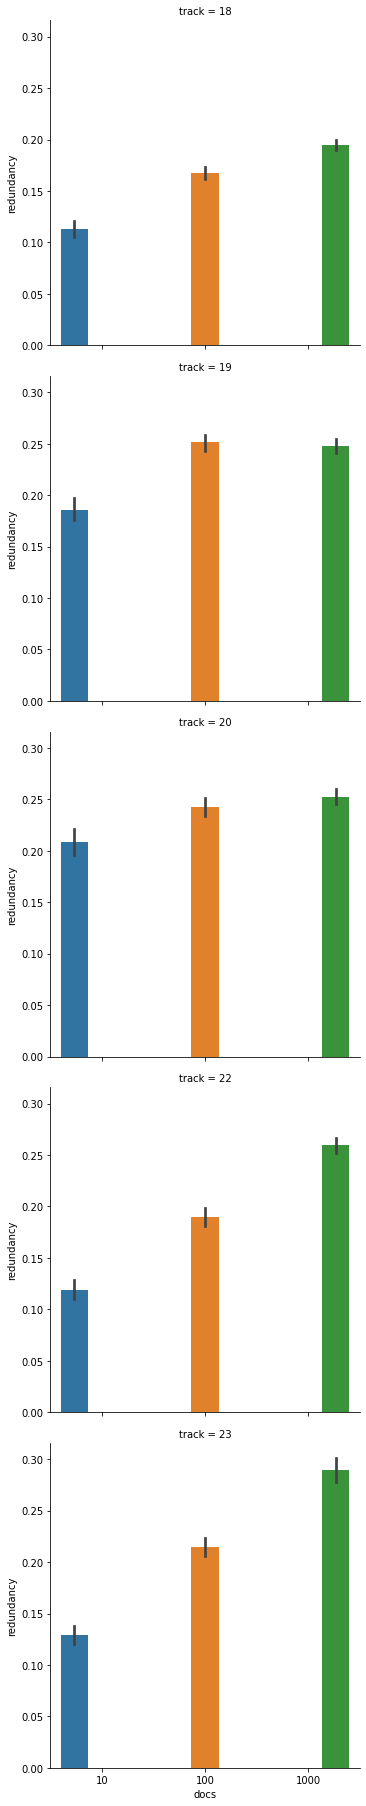

In [160]:
sns.catplot(data=df, kind='bar', x='docs', y='redundancy', row='track', hue='docs')

In [216]:
df_qrels = pd.read_json(DIR + 'redundant-in-runs-qrels.jsonl', lines=True)

df_qrels

,topic,duplicates,docs,redundancy,year
0,1,77,246,0.313008,2009
1,2,35,221,0.158371,2009
2,3,31,286,0.108392,2009
3,4,59,270,0.218519,2009
4,5,17,230,0.073913,2009
...,...,...,...,...,...
293,296,61,250,0.244000,2014
294,297,30,228,0.131579,2014
295,298,29,249,0.116466,2014
296,299,35,241,0.145228,2014


In [217]:
df_qrels_relevant = pd.read_json(DIR + 'redundant-in-qrels-relevant.jsonl', lines=True)

df_qrels_relevant

,topic,duplicates,docs,redundancy,year
0,1,58,246,0.235772,2009
1,2,14,221,0.063348,2009
2,3,5,286,0.017483,2009
3,4,0,270,0.000000,2009
4,5,0,230,0.000000,2009
...,...,...,...,...,...
293,296,42,250,0.168000,2014
294,297,23,228,0.100877,2014
295,298,17,249,0.068273,2014
296,299,19,241,0.078838,2014


In [218]:
df_qrels_irrelevant = pd.read_json(DIR + 'redundant-in-qrels-irrelevant.jsonl', lines=True)

df_qrels_irrelevant

,topic,duplicates,docs,redundancy,year
0,1,15,246,0.060976,2009
1,2,19,221,0.085973,2009
2,3,25,286,0.087413,2009
3,4,58,270,0.214815,2009
4,5,17,230,0.073913,2009
...,...,...,...,...,...
293,296,7,250,0.028000,2014
294,297,5,228,0.021930,2014
295,298,11,249,0.044177,2014
296,299,15,241,0.062241,2014


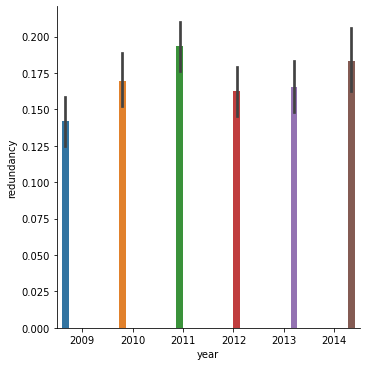

In [167]:
sns.catplot(data=df_qrels, kind='bar', x='year', y='redundancy', hue='year')

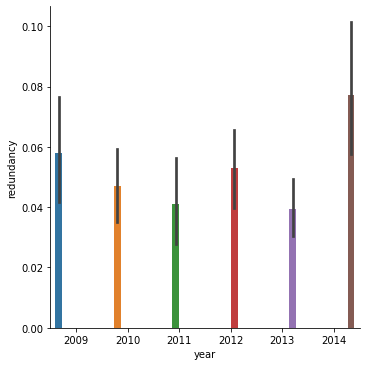

In [219]:
sns.catplot(data=df_qrels_relevant, kind='bar', x='year', y='redundancy', hue='year')

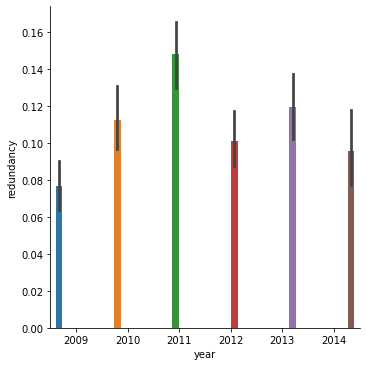

In [220]:
sns.catplot(data=df_qrels_irrelevant, kind='bar', x='year', y='redundancy', hue='year')

In [212]:
sns.catplot(data=df_qrels_relvant, kind='bar', x='year', y='redundancy', hue='year')

NameError: name 'df_qrels_relvant' is not defined

In [133]:
DEDUP_TARGET_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/trec20-web.adhoc-top25/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df_25 = eval_runs_with_threshold(0.82, ALL_DIRS)
df_25['redundancy'] = df_25['duplicates']/df_25['docs']
df_25 = df_25[(df_25['docs'] >= 24) & (df_25['docs'] < 27)]
df_25['docs'] = 25

DEDUP_TARGET_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/trec20-web.adhoc-top10/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df_10 = eval_runs_with_threshold(0.82, ALL_DIRS)
df_10['redundancy'] = df_10['duplicates']/df_10['docs']
df_10 = df_10[(df_10['docs'] >= 9) & (df_10['docs'] < 12)]
df_10['docs'] = 10
df_10[['docs', 'redundancy']].groupby('docs').mean()

DEDUP_TARGET_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/trec20-web.adhoc-top100/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df_2 = eval_runs_with_threshold(0.82, ALL_DIRS)
df_2['redundancy'] = df_2['duplicates']/df_2['docs']
df_2 = df_2[(df_2['docs'] >= 99) & (df_2['docs'] < 102)]
df_2['docs'] = 100

DEDUP_TARGET_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/trec20-web.adhoc-top1000/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df_3 = eval_runs_with_threshold(0.82, ALL_DIRS)
df_3['redundancy'] = df_3['duplicates']/df_3['docs']
df_3 = df_3[(df_3['docs'] >= 990) & (df_3['docs'] < 1002)]
df_3['docs'] = 1000


df = pd.concat([df_10, df_2, df_3])

In [134]:
df[['docs', 'redundancy']].groupby('docs').mean()

,redundancy
docs,
10,0.230555
100,0.241681
1000,0.284545


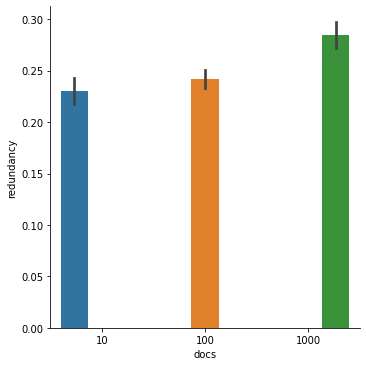

In [138]:
sns.catplot(data=df, kind='bar', x='docs', y='redundancy', hue='docs')

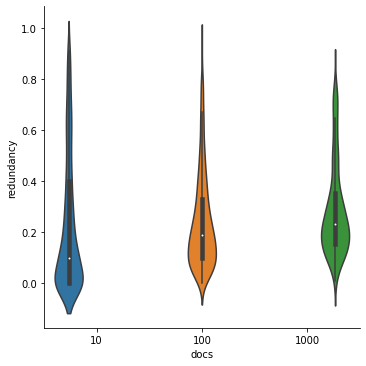

In [139]:
sns.catplot(data=df, kind='violin', x='docs', y='redundancy', hue='docs')

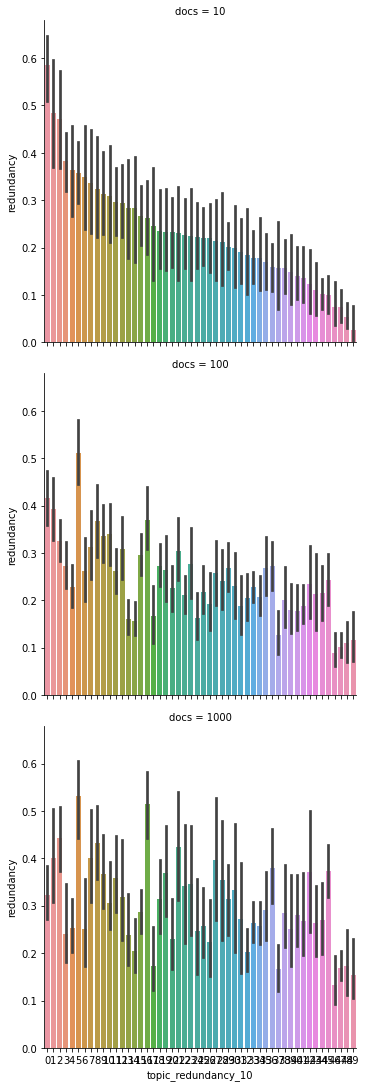

In [140]:
def topic_to_pos(df, num_docs):
    tmp = df[df['docs'] == num_docs][['topic', 'redundancy']].groupby('topic').mean().reset_index().sort_values('redundancy', ascending=False)
    ret = {}
    for i in range(0, len(tmp)):
        ret[tmp.iloc[i]['topic']] = i
        
    return ret

tmp_df = df.copy()
topic_redundancy_10 = topic_to_pos(tmp_df, 10)
tmp_df['topic_redundancy_10'] = tmp_df.topic.apply(lambda i: topic_redundancy_10[i])
topic_redundancy_100 = topic_to_pos(tmp_df, 100)
tmp_df['topic_redundancy_100'] = tmp_df.topic.apply(lambda i: topic_redundancy_100[i])
topic_redundancy_1000 = topic_to_pos(tmp_df, 1000)
tmp_df['topic_redundancy_1000'] = tmp_df.topic.apply(lambda i: topic_redundancy_1000[i])

sns.catplot(data=tmp_df, kind='bar', x='topic_redundancy_10', y='redundancy', row='docs')

In [144]:
import json
import pandas as pd
import seaborn as sns
from trectools import TrecQrel

qrels = TrecQrel('qrels.web.101-150.txt')

def eval_with_threshold(threshold, run_file_name):
    rows = []
    with open(run_file_name) as jsonl_file:
        for jsonl in jsonl_file:
            dedup_data = json.loads(jsonl)
            topic = dedup_data['topic']
            judged_docs = qrels.get_document_names_for_topic(int(topic))
            
            for sim in dedup_data['similarities']:
                is_judged = sim['firstId'] in judged_docs or sim['secondId'] in judged_docs
                is_relevant = False
                is_irrelevant = False
                
                if is_judged:
                    judgment_a = qrels.get_judgement(sim['firstId'], int(topic))
                    judgment_b = qrels.get_judgement(sim['secondId'], int(topic))
                    is_irrelevant = judgment_a == 0 or judgment_b == 0
                    is_relevant = not is_irrelevant
                
                rows += [{
                    'topic': topic,
                    'judged': is_judged,
                    'relevant': is_relevant,
                    'irrelevant': is_irrelevant,
                    'near-duplicate': sim['similarities']['s3'] >=  threshold,
                    'simhash(3+5-grams)': sim['similarities']['simhash(3+5-grams)'] > 0.94,
                    'simhash(1-grams)': sim['similarities']['simhash(1-grams)'] > 0.94,
                    'url': sim['similarities']['url'] > 0.5,
                    'text-profile': sim['similarities']['text-profile'] > 0.5,
                    'md5': sim['similarities']['md5'] > 0.5,
                    'copy-cat': ((sim['similarities']['simhash(3+5-grams)'] > 0.94) or ((sim['similarities']['url'] > 0.5) and (sim['similarities']['simhash(1-grams)'] > 0.94))),
                    'copy-cat-tp': ((sim['similarities']['simhash(3+5-grams)'] > 0.94) or (sim['similarities']['text-profile'] > 0.5) or ((sim['similarities']['url'] > 0.5) and (sim['similarities']['simhash(1-grams)'] > 0.94)))
                }]

    return rows

def eval_runs_with_threshold(threshold, run_files):
    rows = []
    for r in run_files:
        rows += eval_with_threshold(threshold, r)
    
    return pd.DataFrame(rows)

In [145]:
DEDUP_TARGET_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/trec20-web.adhoc-top10/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df_10_precision_recall = eval_runs_with_threshold(0.82, ALL_DIRS)

In [106]:
DEDUP_TARGET_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/trec20-web.adhoc-top100/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]


df_100_precision_recall = eval_runs_with_threshold(0.82, ALL_DIRS)

In [108]:
DEDUP_TARGET_DIR='/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/trec20-web.adhoc-top1000/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]
#FIXME: Only for intermediate processing
ALL_DIRS = [i for i in ALL_DIRS if 'umassIFuse.jsonl' not in i]


df_1000_precision_recall = eval_runs_with_threshold(0.82, ALL_DIRS)

In [146]:
def precision_score(df, approach):
    from sklearn.metrics import precision_score
    return "{:0.3f}".format(precision_score(y_true=df['near-duplicate'], y_pred=df[approach]))

def recall_score(df, approach):
    from sklearn.metrics import recall_score
    return "{:0.3f}".format(recall_score(y_true=df['near-duplicate'], y_pred=df[approach]))

def table_row(df, approach, approach_display_name):
    ret = {'Approach': approach_display_name}

    for doc_count in [10, 100, 1000]:
        df_current_count = df[df['docs'] == doc_count]
        doc_count = str(doc_count)
        df_relevant = df_current_count[(df_current_count['judged']) & (df_current_count['relevant'])]
        df_irrelevant = df_current_count[(df_current_count['judged']) & (~df_current_count['relevant'])]

        ret['Precision (Top' + doc_count + ')'] = precision_score(df_current_count, approach)
        ret['Recall (Top' + doc_count + ')'] = recall_score(df_current_count, approach)
        ret['Precision (Relevant@Top' + doc_count + ')'] = precision_score(df_relevant, approach)
        ret['Recall (Relevant@Top' + doc_count + ')'] = recall_score(df_relevant, approach)
        ret['Precision (Irrelevant@Top' + doc_count + ')'] = precision_score(df_irrelevant, approach)
        ret['Recall (Irrelevant@Top' + doc_count + ')'] = recall_score(df_irrelevant, approach)
    
    return ret

def report_table(df):
    rows = []
    for approach, approach_display_name in [('copy-cat-tp', 'CopyCat'), ('simhash(1-grams)', 'SimHash(1-grams)'), ('simhash(3+5-grams)', 'SimHash(3+5-grams)'), ('text-profile', 'TextProfile') , ('md5', 'MD5')]:
        rows += [table_row(df, approach, approach_display_name)]
    ret = pd.DataFrame(rows)
    ret.set_index('Approach', inplace=True)
    ret.columns = pd.MultiIndex.from_tuples([
        
        ('Top10', 'Precision'), ('Top10', 'Recall'),
        ('Relevant@Top10', 'Precision'), ('Relevant@Top10', 'Recall'),
        ('Irrelevant@Top10', 'Precision'), ('Irrelevant@Top10', 'Recall'),
        
        ('Top100', 'Precision'), ('Top100', 'Recall'),
        ('Relevant@Top100', 'Precision'), ('Relevant@Top100', 'Recall'),
        ('Irrelevant@Top100', 'Precision'), ('Irrelevant@Top100', 'Recall'),
        
        ('Top1000', 'Precision'), ('Top1000', 'Recall'),
        ('Relevant@Top1000', 'Precision'), ('Relevant@Top1000', 'Recall'),
        ('Irrelevant@Top1000', 'Precision'), ('Irrelevant@Top1000', 'Recall'),
    ])

    return ret.reset_index()

print('Precision/Recall with S3 score as ground-truth (small cw09 sample):')
df_10_precision_recall['docs'] = 10
df_100_precision_recall['docs'] = 100
df_1000_precision_recall['docs'] = 1000
df_prec_recall = report_table(pd.concat([df_10_precision_recall, df_100_precision_recall, df_1000_precision_recall]))
df_prec_recall

Precision/Recall with S3 score as ground-truth (small cw09 sample):


Approach     Top10        Relevant@Top10        Irrelevant@Top10  \
                      Precision Recall      Precision Recall        Precision   
0             CopyCat     0.990  0.417          1.000  0.845            0.994   
1    SimHash(1-grams)     0.599  0.839          0.985  0.957            0.948   
2  SimHash(3+5-grams)     0.992  0.348          1.000  0.654            0.996   
3         TextProfile     0.995  0.161          1.000  0.319            1.000   
4                 MD5     1.000  0.083          1.000  0.120            1.000   

            Top100        Relevant@Top100        Irrelevant@Top100         \
  Recall Precision Recall       Precision Recall         Precision Recall   
0  0.803     0.995  0.637           0.996  0.838             0.994  0.674   
1  0.930     0.863  0.817           0.943  0.964             0.957  0.817   
2  0.675     0.997  0.546           1.000  0.695             0.996  0.580   
3  0.289     0.998  0.260           0.999  0.397             0.999  0.256   
4  0.130     1.000  0.130           1.000  0.213             1.000  0.152   

    Top1000        Relevant@Top1000        Irrelevant@Top1000         
  Precision Recall        Precision Recall          Precision Recall  
0     0.984  0.398            0.994  0.799              0.995  0.593  
1     0.853  0.576            0.941  0.942              0.869  0.784  
2     0.994  0.345            1.000  0.668              0.999  0.513  
3     0.979  0.152            0.997  0.366              0.998  0.233  
4     1.000  0.057            1.000  0.242              1.000  0.157

In [147]:
df_prec_recall[df_prec_recall['Approach'].isin(['CopyCat', 'TextProfile', 'MD5'])]

Approach     Top10        Relevant@Top10        Irrelevant@Top10         \
               Precision Recall      Precision Recall        Precision Recall   
0      CopyCat     0.990  0.417          1.000  0.845            0.994  0.803   
3  TextProfile     0.995  0.161          1.000  0.319            1.000  0.289   
4          MD5     1.000  0.083          1.000  0.120            1.000  0.130   

     Top100        Relevant@Top100        Irrelevant@Top100          Top1000  \
  Precision Recall       Precision Recall         Precision Recall Precision   
0     0.995  0.637           0.996  0.838             0.994  0.674     0.984   
3     0.998  0.260           0.999  0.397             0.999  0.256     0.979   
4     1.000  0.130           1.000  0.213             1.000  0.152     1.000   

         Relevant@Top1000        Irrelevant@Top1000         
  Recall        Precision Recall          Precision Recall  
0  0.398            0.994  0.799              0.995  0.593  
3  0.152            0.997  0.366              0.998  0.233  
4  0.057            1.000  0.242              1.000  0.157

In [ ]:
def precision_score(df, approach):
    from sklearn.metrics import precision_score
    return "{:0.3f}".format(precision_score(y_true=df['near-duplicate'], y_pred=df[approach]))

def recall_score(df, approach):
    from sklearn.metrics import recall_score
    return "{:0.3f}".format(recall_score(y_true=df['near-duplicate'], y_pred=df[approach]))

def table_row(df, approach, approach_display_name):
    ret = {'Approach': approach_display_name}

    for doc_count in [10, 100, 1000]:
        df_current_count = df[df['docs'] == doc_count]
        doc_count = str(doc_count)
        df_relevant = df_current_count[(df_current_count['judged']) & (df_current_count['relevant'])]
        df_irrelevant = df_current_count[(df_current_count['judged']) & (~df_current_count['relevant'])]

        ret['Precision (Top' + doc_count + ')'] = precision_score(df_current_count, approach)
        ret['Recall (Top' + doc_count + ')'] = recall_score(df_current_count, approach)
        ret['Precision (Relevant@Top' + doc_count + ')'] = precision_score(df_relevant, approach)
        ret['Recall (Relevant@Top' + doc_count + ')'] = recall_score(df_relevant, approach)
        ret['Precision (Irrelevant@Top' + doc_count + ')'] = precision_score(df_irrelevant, approach)
        ret['Recall (Irrelevant@Top' + doc_count + ')'] = recall_score(df_irrelevant, approach)
    
    return ret

def report_table(df):
    rows = []
    for approach, approach_display_name in [('copy-cat-tp', 'CopyCat'), ('simhash(1-grams)', 'SimHash(1-grams)'), ('simhash(3+5-grams)', 'SimHash(3+5-grams)'), ('text-profile', 'TextProfile') , ('md5', 'MD5')]:
        rows += [table_row(df, approach, approach_display_name)]
    ret = pd.DataFrame(rows)
    ret.set_index('Approach', inplace=True)
    ret.columns = pd.MultiIndex.from_tuples([
        
        ('Top10', 'Precision'), ('Top10', 'Recall'),
        ('Relevant@Top10', 'Precision'), ('Relevant@Top10', 'Recall'),
        ('Irrelevant@Top10', 'Precision'), ('Irrelevant@Top10', 'Recall'),
        
        ('Top100', 'Precision'), ('Top100', 'Recall'),
        ('Relevant@Top100', 'Precision'), ('Relevant@Top100', 'Recall'),
        ('Irrelevant@Top100', 'Precision'), ('Irrelevant@Top100', 'Recall'),
        
        ('Top1000', 'Precision'), ('Top1000', 'Recall'),
        ('Relevant@Top1000', 'Precision'), ('Relevant@Top1000', 'Recall'),
        ('Irrelevant@Top1000', 'Precision'), ('Irrelevant@Top1000', 'Recall'),
    ])

    return ret.reset_index()

print('Precision/Recall with S3 score as ground-truth (small cw09 sample):')
df_10_precision_recall['docs'] = 10
df_100_precision_recall['docs'] = 100
df_1000_precision_recall['docs'] = 1000
df_prec_recall = report_table(pd.concat([df_10_precision_recall, df_100_precision_recall, df_1000_precision_recall]))
df_prec_recall

In [204]:
df_tmp = pd.read_json('/mnt/ceph/storage/data-in-progress/data-research/web-search/SIGIR-21/sigir21-deduplicate-trec-run-files/metadata/web-track-18-precision-recall.jsonl', lines=True)


In [206]:
df_tmp[df_tmp['judged']]

,topic,judged,relevant,irrelevant,near-duplicate,simhash(3+5-grams),simhash(1-grams),url,text-profile,md5,copy-cat,copy-cat-tp
11,1,True,True,False,False,False,False,False,False,False,False,False
14,1,True,True,False,False,False,False,False,False,False,False,False
17,1,True,False,True,True,False,False,False,False,False,False,False
19,1,True,True,False,False,False,False,False,False,False,False,False
35,1,True,True,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3090367,20,True,False,True,True,False,True,False,True,False,False,True
3090386,20,True,False,True,True,False,True,False,True,False,False,True
3090394,20,True,False,True,True,True,True,False,True,False,True,True
3090400,20,True,False,True,False,False,False,False,False,False,False,False
